In [56]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [57]:
# File Directory for both the train and test
train_path = "chest-ctscan-images/Data/train"
val_path = "chest-ctscan-images/Data/valid"
test_path = "chest-ctscan-images/Data/test"

In [58]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)))
    return num_of_image

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


In [59]:
train_datagen = image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size=5,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.


In [60]:
val_datagen = image.ImageDataGenerator(rescale=1.0/255.0)
val_data = val_datagen.flow_from_directory(
    val_path,
    batch_size=5,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 72 images belonging to 4 classes.


In [61]:
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)
test_data = test_datagen.flow_from_directory(
    test_path,
    batch_size=5,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 315 images belonging to 4 classes.


In [62]:
# MobileNet Model
mob_model = MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [63]:
for layer in mob_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(mob_model.output)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 nodes for classification output
output = Dense(4, activation='sigmoid')(x)

In [64]:
model_mobnet = Model(mob_model.input, output)

model_mobnet.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
mc = ModelCheckpoint(
    filepath="./mobnet_model.hdf5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

In [66]:
# Fitting the Model
history = model_mobnet.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=35,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[mc]
)

Epoch 1/35
122/122 [==============================] - ETA: 0s - loss: 1.1402 - accuracy: 0.4918
Epoch 1: val_accuracy improved from -inf to 0.51429, saving model to .\mobnet_model.hdf5
122/122 [==============================] - 70s 416ms/step - loss: 1.1402 - accuracy: 0.4918 - val_loss: 0.9128 - val_accuracy: 0.5143
Epoch 2/35
122/122 [==============================] - ETA: 0s - loss: 0.8069 - accuracy: 0.6349
Epoch 2: val_accuracy improved from 0.51429 to 0.58571, saving model to .\mobnet_model.hdf5
122/122 [==============================] - 48s 391ms/step - loss: 0.8069 - accuracy: 0.6349 - val_loss: 0.8205 - val_accuracy: 0.5857
Epoch 3/35
122/122 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.7007
Epoch 3: val_accuracy improved from 0.58571 to 0.62857, saving model to .\mobnet_model.hdf5
122/122 [==============================] - 48s 393ms/step - loss: 0.6981 - accuracy: 0.7007 - val_loss: 0.8644 - val_accuracy: 0.6286
Epoch 4/35
122/122 [=================

In [67]:
model_mobnet = load_model("mobnet_model.hdf5")

In [68]:
# Evaluate the Model
test_score = model_mobnet.evaluate(test_data)
accuracy = test_score[1] * 100
print(f"Test Accuracy Mobile Net: {accuracy:.2f}%")
loss = test_score[0] * 100
print(f"Model Loss: {loss:.2f}%")

63/63 [==============================] - 20s 296ms/step - loss: 0.5084 - accuracy: 0.8444
Test Accuracy Mobile Net: 84.44%
Model Loss: 50.84%


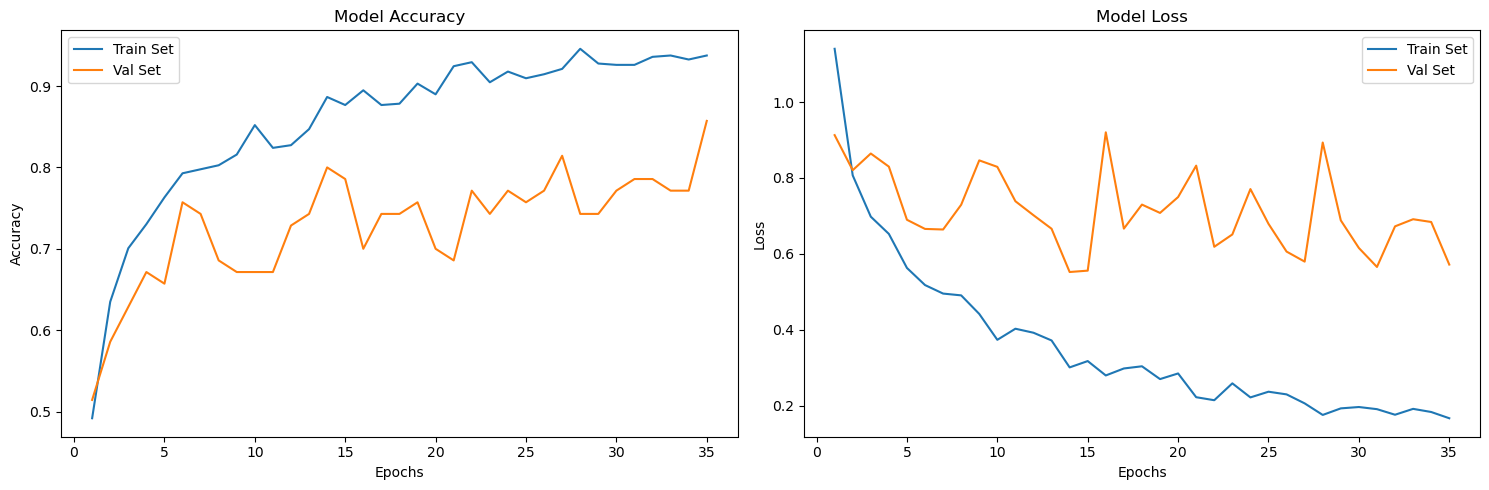

In [69]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [70]:
def chestScanPrediction(path, model):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]

    # Loading Image
    img = image.load_img(path, target_size=(224, 224))
    # Converting Image to Numpy Array
    input_arr = image.img_to_array(img)
    # Preprocess the input image
    input_arr = tf.keras.applications.mobilenet.preprocess_input(input_arr)
    # Adding extra dimension to match the model input shape
    input_arr = np.expand_dims(input_arr, axis=0)

    # Getting Predictions
    pred = model.predict(input_arr)
    # Converting probability to percentage
    prob = round(np.max(pred) * 100, 2)
    # Getting predicted class index
    pred_index = np.argmax(pred)
    # Getting predicted class
    pred_class = classes_dir[pred_index]

    # Returning prediction result
    return {"class": pred_class, "probability": prob}


In [71]:
# path = "chest-ctscan-images/Data/test/large.cell.carcinoma/000110.png"
# path = "chest-ctscan-images/Data/test/adenocarcinoma/000114.png"
path = "chest-ctscan-images/Data/test/squamous.cell.carcinoma/000119.png"
# path = "chest-ctscan-images/Data/test/normal/7.png"
chestScanPrediction(path,model_mobnet)

1/1 [==============================] - 1s 1s/step


{'class': 'Squamous cell carcinoma', 'probability': 97.83}